In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

import sys
sys.path.append('../')

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tueplots import bundles

from configs.configs import get_butterflies_eulerian_independent_config
from src.data.butterflies import Butterfly
from src.models.diffusion.diffuser import Diffuser1D
from src.models.diffusion.sde import SDE
from src.utils.trainer import TrainerModule, Model
from src.utils.plotting import plot_2d_trajectories_in_3d, plot_trajectories
# from src.utils.util import use_cpu_backend

LOAD_PATH = "../results/butterfly_eulerian_independent_g2score/"

2024-05-22 16:52:34.520535: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-22 16:52:34.520576: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-22 16:52:34.522534: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-22 16:52:35.854365: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# Some plot settings for NeuraIPS
plt.rcParams.update(
    bundles.neurips2024(
        family="sans-serif",
        usetex=False,
    ))

In [10]:
X0 = Butterfly("polytes_pts", interp=300, interp_method="linear")
XT = Butterfly("honrathi_pts", interp=300, interp_method="linear")

config = get_butterflies_eulerian_independent_config()
config.training.dir = LOAD_PATH
config.sde.X0 = X0
sde = SDE(**config.sde)

In [7]:
# Simulate the estimated bridge
trainer = TrainerModule(config)
trainer.train_model(pretrained=True, step=20)
model = Model(trainer, dim=1)
diffuser = Diffuser1D(config.training.seed, sde=sde)

In [23]:
n_eval_pts = 64
y0 = (XT.sample(n_eval_pts) - X0.sample(n_eval_pts)).flatten()
ts = jnp.linspace(0.0, 1.0, 200)
ys = diffuser.solve_reverse_bridge_sde(rng_key=jax.random.PRNGKey(config.training.seed), x0=y0, ts=ts, model=model)
ys = ys.reshape((len(ts), n_eval_pts, 2))

<Axes3D: xlabel='$x$', ylabel='$y$', zlabel='$t$'>

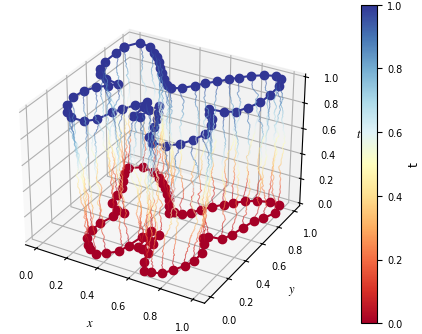

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plot_2d_trajectories_in_3d(ax, 
                        traj=ys+X0.sample(n_eval_pts)[None, ...],
                        target=None,
                        cmap_name="RdYlBu")
# fig.savefig(f"../assets/butterfly_bridge_{n_eval_pts}pts_3d.pdf", bbox_inches="tight", dpi=150)

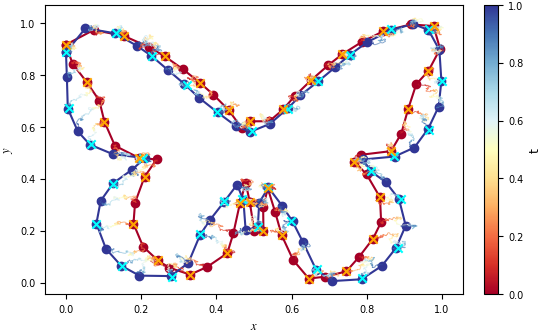

In [24]:
fig, ax = plt.subplots()
plot_trajectories(
    dim=2,
    ax=ax, 
    traj=ys+X0.sample(n_eval_pts)[None, ...],
    target=None,
    cmap_name="RdYlBu")
sm = plt.cm.ScalarMappable(cmap="RdYlBu", norm=plt.Normalize(vmin=0, vmax=1))
ax.scatter(*X0.sample(n_eval_pts)[::(n_eval_pts//32)].T, c="cyan", marker="x", zorder=3)
ax.scatter(*XT.sample(n_eval_pts)[::(n_eval_pts//32)].T, c="orange", marker="x", zorder=3)
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("t")
fig.savefig(f"../assets/butterfly_bridge_{n_eval_pts}pts.pdf", bbox_inches="tight", dpi=150)

In [4]:
X0 = Butterfly("archon_apollinus", interp=None)
LOAD_PATH = "../results/butterfly_eulerian_independent_g2score_archon_apollinus/"
config = get_butterflies_eulerian_independent_config()
config.training.dir = LOAD_PATH
config.sde.X0 = X0
sde = SDE(**config.sde)

trainer = TrainerModule(config)
trainer.train_model(pretrained=True)
model = Model(trainer, dim=1)

In [5]:
rng_key = jax.random.PRNGKey(config.training.seed)

In [8]:
def simulate_bridge(XT, n_eval_pts, rng_key):
    y0 = (XT.sample(n_eval_pts) - X0.sample(n_eval_pts)).flatten()
    ts = jnp.linspace(0.0, 1.0, 200)
    ys = trainer.diffuser.solve_reverse_bridge_sde(rng_key=rng_key, x0=y0, ts=ts, model=model)
    ys = ys.reshape((len(ts), n_eval_pts, 2))
    ys = X0.sample(n_eval_pts)[None, ...] + ys
    return ys

In [9]:
# allancastria_cerisyi
XT = Butterfly("allancastria_cerisyi", interp=None)
rng_key, subkey = jax.random.split(rng_key)
ys = simulate_bridge(XT, 128, subkey)

In [12]:
def plot_traj(traj):
    fig, ax = plt.subplots()
    plot_trajectories(
        dim=2,
        ax=ax, 
        traj=traj,
        target=None,
        cmap_name="RdYlBu")
    ax.set_aspect("equal")
    sm = plt.cm.ScalarMappable(cmap="RdYlBu", norm=plt.Normalize(vmin=0, vmax=1))
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label("t")
    return fig, ax

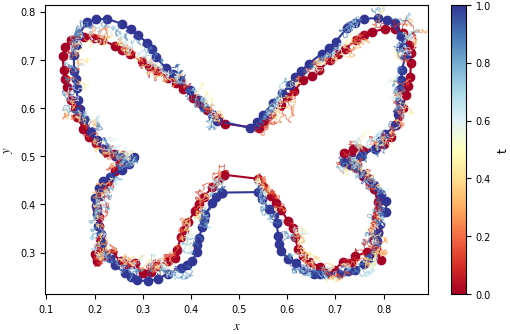

In [14]:
fig, ax = plot_traj(ys)
fig.savefig("../assets/butterfly_bridge_allancastria_cerisyi_archo_apollinus.pdf", bbox_inches="tight", dpi=150)

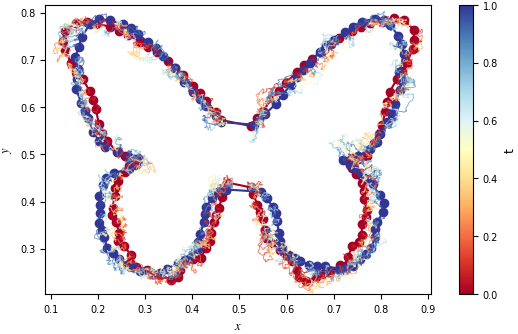

In [15]:
# battus_polydamas
XT = Butterfly("battus_polydamas", interp=None)
rng_key, subkey = jax.random.split(rng_key)
ys = simulate_bridge(XT, 128, subkey)
fig, ax = plot_traj(ys)
fig.savefig("../assets/butterfly_bridge_battus_polydamas_archo_apollinus.pdf", bbox_inches="tight", dpi=150)

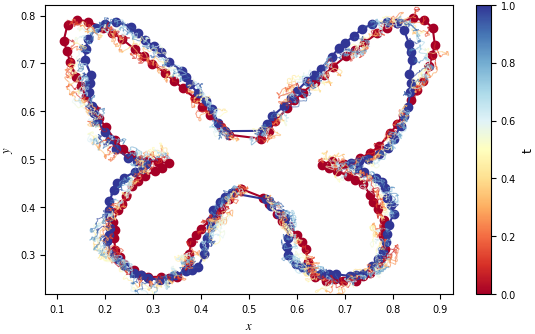

In [16]:
# cressida_cressida
XT = Butterfly("cressida_cressida", interp=None)
rng_key, subkey = jax.random.split(rng_key)
ys = simulate_bridge(XT, 128, subkey)
fig, ax = plot_traj(ys)
fig.savefig("../assets/butterfly_bridge_cressida_cressida_archo_apollinus.pdf", bbox_inches="tight", dpi=150)

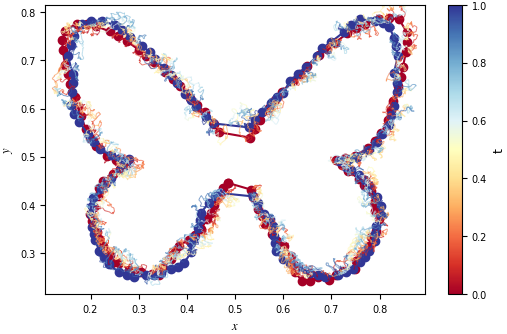

In [17]:
# euryades_corethrus
XT = Butterfly("euryades_corethrus", interp=None)
rng_key, subkey = jax.random.split(rng_key)
ys = simulate_bridge(XT, 128, subkey)
fig, ax = plot_traj(ys)
fig.savefig("../assets/butterfly_bridge_euryades_corethrus_archo_apollinus.pdf", bbox_inches="tight", dpi=150)

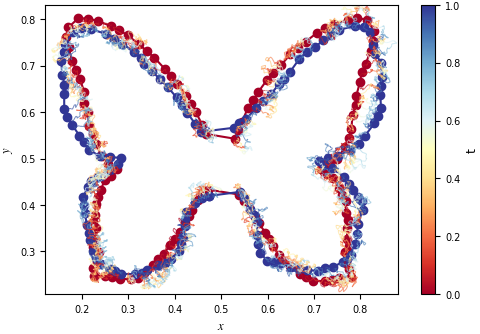

In [18]:
# graphium_agamemnon
XT = Butterfly("graphium_agamemnon", interp=None)
rng_key, subkey = jax.random.split(rng_key)
ys = simulate_bridge(XT, 128, subkey)
fig, ax = plot_traj(ys)
fig.savefig("../assets/butterfly_bridge_graphium_agamemnon_archo_apollinus.pdf", bbox_inches="tight", dpi=150)